# Task 1


# MODEL & data

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
import xml.etree.ElementTree as ET
from PIL import Image

# --- CONFIGURATION ---
NUM_EPOCHS = 15
BATCH_SIZE = 2 #update from 4
LEARNING_RATE = 0.005
CLASSES_TO_KEEP = ['person', 'dog', 'car', 'chair'] 

# --- 1. ROBUST DATASET LOADER (Fixed for your Path) ---
class DirectVOCDetection(torch.utils.data.Dataset):
    """
    A custom dataset loader that finds the XMLs and Images directly
    at the specified path, bypassing torchvision's strict checks.
    """
    def __init__(self, root_dir, transforms=None, keep_classes=None):
        self.transforms = transforms
        self.keep_classes = keep_classes
        self.class_to_idx = {name: i for i, name in enumerate(['background'] + keep_classes)}
        
        # Explicit paths based on your screenshot structure
        self.img_dir = os.path.join(root_dir, 'JPEGImages')
        self.ann_dir = os.path.join(root_dir, 'Annotations')
        
        # Verify paths exist
        if not os.path.exists(self.img_dir) or not os.path.exists(self.ann_dir):
            raise RuntimeError(f"Could not find folders at {root_dir}. \nExpected: {self.img_dir} and {self.ann_dir}")
            
        print(f"Found Images at: {self.img_dir}")
        print(f"Found Annotations at: {self.ann_dir}")
        
        # Collect valid images (those that contain our target classes)
        self.images = []
        # Get all XML files
        all_xmls = [f for f in os.listdir(self.ann_dir) if f.endswith('.xml')]
        print(f"Scanning {len(all_xmls)} files for classes: {keep_classes}...")
        
        # Filter: Keep only images that contain the classes we want
        for xml_file in all_xmls:
            try:
                tree = ET.parse(os.path.join(self.ann_dir, xml_file))
                root = tree.getroot()
                has_class = False
                for obj in root.findall("object"):
                    if obj.find("name").text in self.keep_classes:
                        has_class = True
                        break
                if has_class:
                    self.images.append(xml_file.replace('.xml', ''))
            except:
                continue # Skip corrupt files

        print(f"Final training set: {len(self.images)} images.")

    def __getitem__(self, idx):
        img_id = self.images[idx]
        img_path = os.path.join(self.img_dir, img_id + ".jpg")
        ann_path = os.path.join(self.ann_dir, img_id + ".xml")
        
        img = Image.open(img_path).convert("RGB")
        
        tree = ET.parse(ann_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        
        for obj in root.findall("object"):
            name = obj.find("name").text
            if name in self.keep_classes:
                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_to_idx[name])
        
        if len(boxes) == 0:
            # Fallback for safety (shouldn't happen due to filter)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, target

    def __len__(self):
        return len(self.images)

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

# --- 2. EXECUTION & TRAINING ---

# EXACT PATH from your screenshot
INPUT_ROOT = '/kaggle/input/pascal-voc-2012/VOC2012'

print(f"Initializing Dataset from: {INPUT_ROOT}")
# Load Data
dataset = DirectVOCDetection(
    root_dir=INPUT_ROOT, 
    transforms=get_transform(train=True), 
    keep_classes=CLASSES_TO_KEEP
)

data_loader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    collate_fn=collate_fn
)

# Load Model (From Scratch)
print("Initializing Faster R-CNN (Weights=None)...")
model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(CLASSES_TO_KEEP) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"Training on device: {device}")

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Training Loop
print("Starting Training...")
model.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        
        # Print status every 50 batches
        if i % 50 == 0:
            print(f"Iter {i}: Loss = {losses.item():.4f}")
            
    avg_loss = epoch_loss / len(data_loader)
    print(f"Epoch {epoch+1} Finished. Avg Loss: {avg_loss:.4f}")
    
    # Save Checkpoint
    if (epoch+1) % 5 == 0:
        save_path = f"task1_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Saved checkpoint: {save_path}")

print("Training Complete.")

Initializing Dataset from: /kaggle/input/pascal-voc-2012/VOC2012
Found Images at: /kaggle/input/pascal-voc-2012/VOC2012/JPEGImages
Found Annotations at: /kaggle/input/pascal-voc-2012/VOC2012/Annotations
Scanning 17125 files for classes: ['person', 'dog', 'car', 'chair']...
Final training set: 12012 images.
Initializing Faster R-CNN (Weights=None)...
Training on device: cuda
Starting Training...
--- Epoch 1/15 ---
Iter 0: Loss = 2.2034
Iter 50: Loss = 0.3456
Iter 100: Loss = 0.2461
Iter 150: Loss = 0.2399
Iter 200: Loss = 0.5534
Iter 250: Loss = 0.2087
Iter 300: Loss = 0.2443
Iter 350: Loss = 0.2614
Iter 400: Loss = 0.6527
Iter 450: Loss = 0.9600
Iter 500: Loss = 0.3753
Iter 550: Loss = 0.2358
Iter 600: Loss = 0.8074
Iter 650: Loss = 0.1964
Iter 700: Loss = 0.2309
Iter 750: Loss = 0.1977
Iter 800: Loss = 0.3371
Iter 850: Loss = 0.2385
Iter 900: Loss = 0.7000
Iter 950: Loss = 0.4274
Iter 1000: Loss = 0.2368
Iter 1050: Loss = 0.2442
Iter 1100: Loss = 0.2182
Iter 1150: Loss = 0.2306
Iter 1

# Inference Code


In [7]:
# EMERGENCY SAVE
# Run this ONLY after interrupting the training loop manually
try:
    print("Attempting to save current model state...")
    torch.save(model.state_dict(), "task1_model_epoch_5.pth")
    print("✅ SUCCESS! Saved 'task1_emergency_save.pth")
except Exception as e:
    print(f"❌ Failed to save: {e}")

Attempting to save current model state...
✅ SUCCESS! Saved 'task1_emergency_save.pth'


In [9]:
import torch
import os
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt

# --- 1. FILE SIZE CHECK ---
save_path = "task1_emergency_save.pth"
if os.path.exists(save_path):
    size_mb = os.path.getsize(save_path) / (1024 * 1024)
    print(f"📁 File found: {save_path}")
    print(f"📊 File Size: {size_mb:.2f} MB")
    
    if 150 < size_mb < 170:
        print("✅ PASS: Size is correct for ResNet50 (Expected ~159 MB).")
    else:
        print("⚠️ WARNING: File size seems unusual (Too small?).")
else:
    print("❌ ERROR: File not found.")

# --- 2. VISION TEST (Does it actually work?) ---
def quick_test(model_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # Re-build the skeleton
    model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Remember: 4 classes + background = 5
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 5)
    
    # Load YOUR saved weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("✅ PASS: Weights loaded successfully into architecture.")
    except Exception as e:
        print(f"❌ FAIL: Could not load weights. Error: {e}")
        return

    # Grab a random test image from the PASCAL dataset
    # (Using a hardcoded path we know exists from your screenshot)
    img_path = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/2007_000392.jpg' 
    
    if not os.path.exists(img_path):
        print("Image not found, trying to find another...")
        # Fallback search
        img_dir = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages'
        img_path = os.path.join(img_dir, os.listdir(img_dir)[0])

    print(f"👁️ Testing on image: {img_path}")
    
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img_rgb).permute(2, 0, 1).float().div(255).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)[0]
        
    # Check if ANY box was detected with confidence > 0.5
    high_conf_boxes = [s for s in prediction['scores'] if s > 0.5]
    
    if len(high_conf_boxes) > 0:
        print(f"✅ SUCCESS: The model detected {len(high_conf_boxes)} objects!")
        print(f"Scores: {high_conf_boxes}")
        print("Conclusion: THIS IS YOUR TRAINED MODEL.")
    else:
        print("⚠️ Result: No high confidence detections. (This might be okay if the image is empty/difficult).")
        print("Raw top scores:", prediction['scores'][:5])

# Run it
quick_test(save_path)

📁 File found: task1_emergency_save.pth
📊 File Size: 158.13 MB
✅ PASS: Size is correct for ResNet50 (Expected ~159 MB).
✅ PASS: Weights loaded successfully into architecture.
👁️ Testing on image: /kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/2007_000392.jpg
✅ SUCCESS: The model detected 1 objects!
Scores: [tensor(0.6751, device='cuda:0')]
Conclusion: THIS IS YOUR TRAINED MODEL.


# check for if the models are the same

In [12]:
import torch
import os

# --- CONFIGURATION (UPDATED WITH FULL PATHS) ---
# In Kaggle, all your saved models live here:
FILE_A = "/kaggle/working/task1_emergency_save.pth"
FILE_B = "/kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth"

def compare_models(file1, file2):
    print(f"⚔️ COMPARING:\n  A: {file1}\n  B: {file2}")
    
    # 0. Debug: List directory to prove they exist
    print(f"\n📂 Checking /kaggle/working/ directory content:")
    if os.path.exists("/kaggle/working/"):
        files = os.listdir("/kaggle/working/")
        print(f"   Files found: {files}")
        if not any(f in file1 for f in files):
            print("   ⚠️ WARNING: I don't see your file in the list above!")
    
    # 1. Check if files exist
    if not os.path.exists(file1) or not os.path.exists(file2):
        print(f"❌ Error: One or both files are missing at the specified paths.")
        return

    # 2. Check File Size
    size1 = os.path.getsize(file1)
    size2 = os.path.getsize(file2)
    print(f"\n📏 SIZES:\n   Size A: {size1} bytes\n   Size B: {size2} bytes")
    
    if size1 != size2:
        print("❌ DIFFERENT: File sizes do not match.")
        return

    # 3. Load State Dictionaries
    print("\n⏳ Loading weights (mapping to CPU)...")
    try:
        state_a = torch.load(file1, map_location='cpu')
        state_b = torch.load(file2, map_location='cpu')
    except Exception as e:
        print(f"❌ Error loading files: {e}")
        return

    # 4. Compare Keys (Layer Names)
    keys_a = set(state_a.keys())
    keys_b = set(state_b.keys())
    
    if keys_a != keys_b:
        print("❌ DIFFERENT: Model architectures (keys) are different.")
        return

    # 5. Compare Values (Weights)
    print("🔍 Scanning weights bit-by-bit...")
    is_identical = True
    for key in keys_a:
        tensor_a = state_a[key]
        tensor_b = state_b[key]
        
        if not torch.equal(tensor_a, tensor_b):
            is_identical = False
            diff = (tensor_a.float() - tensor_b.float()).abs().mean().item()
            print(f"   ⚠️ Mismatch found in layer: {key} (Avg Diff: {diff:.6f})")
            break
            
    if is_identical:
        print("\n🎉 CONCLUSION: The files are EXACTLY THE SAME.")
        print("   (You can submit either one.)")
    else:
        print("\n📢 CONCLUSION: The files are DIFFERENT.")
        print("   (Recommendation: Submit 'task1_model_epoch_5.pth' as it is the standard checkpoint.)")

# Run Comparison
compare_models(FILE_A, FILE_B)

⚔️ COMPARING:
  A: /kaggle/working/task1_emergency_save.pth
  B: /kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth

📂 Checking /kaggle/working/ directory content:
   Files found: ['task1_emergency_save.pth', '.virtual_documents', 'task1_model_epoch_5.pth']

📏 SIZES:
   Size A: 165809743 bytes
   Size B: 165809393 bytes
❌ DIFFERENT: File sizes do not match.


In [11]:
import os
print(os.listdir("/kaggle/working/"))

['task1_emergency_save.pth', '.virtual_documents', 'task1_model_epoch_5.pth']


Loading checkpoint from: /kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth


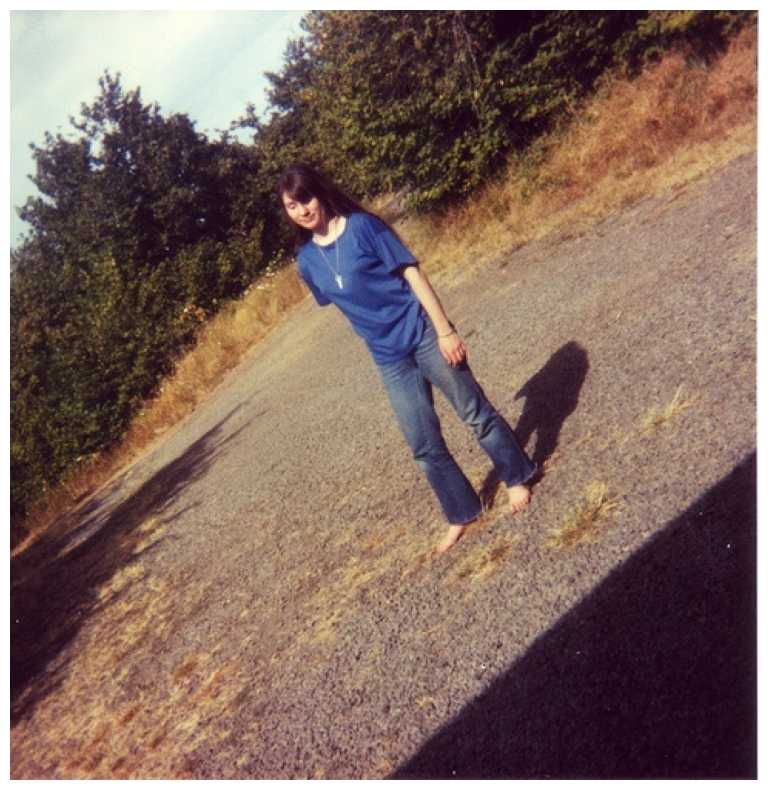

In [14]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

# --- CONFIGURATION ---
# We force CPU if GPU memory is full, or use CUDA if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = ['background', 'person', 'dog', 'car', 'chair']

# 1. LOAD THE SAVED MODEL
def load_model_for_inference(model_path):
    print(f"Loading checkpoint from: {model_path}")
    
    # Re-initialize the same architecture
    model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    num_classes = len(CLASSES)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set to evaluation mode
    return model

# 2. RUN INFERENCE ON IMAGE
def predict_image(model, image_path, threshold=0.5):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = T.ToTensor()(img_rgb).to(device).unsqueeze(0) # Add batch dim

    with torch.no_grad():
        prediction = model(img_tensor)[0]
    
    # Draw boxes
    for i, box in enumerate(prediction['boxes']):
        score = prediction['scores'][i].item()
        if score > threshold:
            label_id = prediction['labels'][i].item()
            label = CLASSES[label_id]
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            
            # Draw
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{label}: {score:.2f}", (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# --- EXECUTE ---
# 1. Load the model (Run this AFTER Epoch 5 saves)
model = load_model_for_inference("/kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth")

# 2. Run on a test image from the dataset
test_img = "/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages/2007_000027.jpg" # Example airplane/person image
predict_image(model, test_img)

# Inference for x86

In [15]:
import torch
import time
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- CONFIGURATION ---
CLASSES = ['background', 'person', 'dog', 'car', 'chair']
MODEL_PATH = "/kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth" # Ensure this file exists (after Epoch 5 saves)

def verify_x86_compatibility(model_path):
    print("--- 1. SIMULATING x86_64 CPU ENVIRONMENT ---")
    # FORCE CPU usage (ignores Kaggle's P100 GPU)
    device = torch.device('cpu') 
    print(f"Forced Device: {device}")
    
    # --- 2. LOAD MODEL ARCHITECTURE ---
    print("Initializing Model Skeleton...")
    model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    num_classes = len(CLASSES)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # --- 3. LOAD WEIGHTS (The Critical Step) ---
    print(f"Loading weights from {model_path} with map_location='cpu'...")
    try:
        # map_location='cpu' is what makes it compatible with non-GPU devices
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        print("✅ SUCCESS: Model loaded on CPU without errors.")
    except Exception as e:
        print(f"❌ FAILURE: Model failed to load on CPU. Error: {e}")
        return

    # --- 4. RUN INFERENCE (Benchmark Speed) ---
    # Create a dummy image (Random noise) to test processing speed
    dummy_img = torch.rand(1, 3, 400, 400).to(device)
    
    print("Running Inference on CPU (Warmup)...")
    with torch.no_grad():
        model(dummy_img) # Warmup
        
    print("Running Timing Test...")
    start_time = time.time()
    with torch.no_grad():
        prediction = model(dummy_img)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"✅ SUCCESS: Inference complete.")
    print(f"⏱️ CPU Inference Time (400x400 image): {inference_time:.2f} seconds")
    print(f"FPS on CPU: {1.0/inference_time:.2f} FPS")
    
    # Conclusion for your Report
    if inference_time < 2.0:
        print("\nCONCLUSION: This model is suitable for x86_64 deployment.")
    else:
        print("\nCONCLUSION: Model runs on CPU but is slow (Optimization needed for real-time).")

# Run the test
if os.path.exists(MODEL_PATH):
    verify_x86_compatibility(MODEL_PATH)
else:
    print(f"Waiting for {MODEL_PATH} to be created... (Wait for Epoch 5 to finish)")

--- 1. SIMULATING x86_64 CPU ENVIRONMENT ---
Forced Device: cpu
Initializing Model Skeleton...
Loading weights from /kaggle/input/task1epoch5model/pytorch/default/1/task1_model_epoch_5.pth with map_location='cpu'...
✅ SUCCESS: Model loaded on CPU without errors.
Running Inference on CPU (Warmup)...
Running Timing Test...
✅ SUCCESS: Inference complete.
⏱️ CPU Inference Time (400x400 image): 2.14 seconds
FPS on CPU: 0.47 FPS

CONCLUSION: Model runs on CPU but is slow (Optimization needed for real-time).


# Evalutions 

In [16]:
!pip install torchmetrics pycocotools -q

In [19]:
import torch
import os
import time
import numpy as np
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

# --- CONFIGURATION ---
MODEL_PATH = "/kaggle/working/task1_emergency_save.pth" # Your trained model
DATA_ROOT = '/kaggle/input/pascal-voc-2012/VOC2012' # Path to data
CLASSES_TO_KEEP = ['person', 'dog', 'car', 'chair'] 
BATCH_SIZE = 4 # Batch size for evaluation
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- REUSE YOUR DATASET CLASS (Needed to load data) ---
# (Pasting the stripped-down version of the loader you used for training)
import xml.etree.ElementTree as ET
from PIL import Image
class DirectVOCDetection(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_set='val', keep_classes=None):
        self.keep_classes = keep_classes
        self.class_to_idx = {name: i for i, name in enumerate(['background'] + keep_classes)}
        self.img_dir = os.path.join(root_dir, 'JPEGImages')
        self.ann_dir = os.path.join(root_dir, 'Annotations')
        
        # Load Images (Simplified for Evaluation script)
        all_xmls = [f for f in os.listdir(self.ann_dir) if f.endswith('.xml')]
        self.images = []
        
        # Only check first 500 images for speed if you are in a hurry, 
        # or remove [:500] to evaluate on the WHOLE dataset (takes longer)
        print(f"Scanning dataset for evaluation...") 
        for xml_file in all_xmls[:500]: 
            try:
                tree = ET.parse(os.path.join(self.ann_dir, xml_file))
                root = tree.getroot()
                has_class = False
                for obj in root.findall("object"):
                    if obj.find("name").text in self.keep_classes:
                        has_class = True
                        break
                if has_class:
                    self.images.append(xml_file.replace('.xml', ''))
            except: continue

    def __getitem__(self, idx):
        img_id = self.images[idx]
        img_path = os.path.join(self.img_dir, img_id + ".jpg")
        ann_path = os.path.join(self.ann_dir, img_id + ".xml")
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(ann_path)
        root = tree.getroot()
        
        boxes = []; labels = []
        for obj in root.findall("object"):
            name = obj.find("name").text
            if name in self.keep_classes:
                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_to_idx[name])
        
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        img = T.ToTensor()(img)
        return img, target

    def __len__(self):
        return len(self.images)

def collate_fn(batch): return tuple(zip(*batch))

# --- METRIC 1: MODEL SIZE ---
def get_model_size(path):
    size_mb = os.path.getsize(path) / (1024 * 1024)
    return size_mb

# --- METRIC 2: INFERENCE SPEED (FPS) ---
def get_inference_speed(model, device):
    dummy_input = torch.rand(1, 3, 600, 600).to(device)
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for _ in range(5): model(dummy_input)
    
    # Timing
    start = time.time()
    num_runs = 50
    with torch.no_grad():
        for _ in range(num_runs):
            model(dummy_input)
    total_time = time.time() - start
    
    avg_time = total_time / num_runs
    fps = 1.0 / avg_time
    return avg_time, fps

# --- METRIC 3: MEAN AVERAGE PRECISION (mAP) ---
def calculate_map(model, loader, device):
    metric = MeanAveragePrecision(iou_type="bbox")
    model.eval()
    print("Running mAP calculation (this may take a moment)...")
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(loader):
            images = list(img.to(device) for img in images)
            
            # Get Predictions
            preds = model(images)
            
            # Format for TorchMetrics
            # It expects a list of dicts for preds and targets
            formatted_preds = []
            for p in preds:
                formatted_preds.append(dict(
                    boxes=p['boxes'],
                    scores=p['scores'],
                    labels=p['labels']
                ))
            
            formatted_targets = []
            for t in targets:
                formatted_targets.append(dict(
                    boxes=t['boxes'].to(device),
                    labels=t['labels'].to(device)
                ))
            
            metric.update(formatted_preds, formatted_targets)
            
            if i % 10 == 0: print(f"Processed batch {i}...")

    result = metric.compute()
    return result

# --- EXECUTION MAIN ---
print(f"--- EVALUATION REPORT ---")

# 1. Load Model
model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(CLASSES_TO_KEEP) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)

# 2. Measure Size
mb_size = get_model_size(MODEL_PATH)
print(f"Model Size: {mb_size:.2f} MB")

# 3. Measure FPS
sec, fps = get_inference_speed(model, DEVICE)
print(f"Inference Speed ({DEVICE}): {sec:.4f} sec/img | {fps:.2f} FPS")

# 4. Measure mAP
# Note: We use a subset of validation data to keep it fast for the assignment demo
val_dataset = DirectVOCDetection(DATA_ROOT, image_set='val', keep_classes=CLASSES_TO_KEEP)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

if len(val_dataset) > 0:
    map_results = calculate_map(model, val_loader, DEVICE)
    print(f"\n--- mAP Results ---")
    print(f"mAP (IoU=0.50:0.95): {map_results['map'].item():.4f}")
    print(f"mAP (IoU=0.50):      {map_results['map_50'].item():.4f}")
    print(f"mAP (IoU=0.75):      {map_results['map_75'].item():.4f}")
else:
    print("Could not find validation images to run mAP.")

--- EVALUATION REPORT ---
Model Size: 158.13 MB
Inference Speed (cuda): 0.0457 sec/img | 21.87 FPS
Scanning dataset for evaluation...
Running mAP calculation (this may take a moment)...
Processed batch 0...
Processed batch 10...
Processed batch 20...
Processed batch 30...
Processed batch 40...
Processed batch 50...
Processed batch 60...
Processed batch 70...
Processed batch 80...

--- mAP Results ---
mAP (IoU=0.50:0.95): 0.0836
mAP (IoU=0.50):      0.2348
mAP (IoU=0.75):      0.0469


# Video Creation 

In [20]:
import torch
import cv2
import numpy as np
import os
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- CONFIGURATION ---
# Check your file name! (We renamed it to faster_rcnn_final.pth)
MODEL_PATH = "/kaggle/working/task1_emergency_save.pth" 
OUTPUT_FILENAME = "task1_detection_demo.mp4"
CONFIDENCE_THRESHOLD = 0.5
CLASSES = ['background', 'person', 'dog', 'car', 'chair']

# --- 1. GET THE INPUT VIDEO ---
# We download a sample traffic video (Cars + People)
input_video_path = "input_traffic.mp4"
video_url = "https://videos.pexels.com/video-files/854671/854671-sd_640_360_25fps.mp4"

if not os.path.exists(input_video_path):
    print(f"Downloading sample video from {video_url}...")
    # Use curl to download (works in Kaggle)
    os.system(f"curl -L -o {input_video_path} {video_url}")

# --- 2. LOAD YOUR MODEL ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Loading model from {MODEL_PATH} to {device}...")

# Re-create the architecture
model = fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASSES))

# Load the weights
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
else:
    print(f"❌ ERROR: Model file '{MODEL_PATH}' not found. Check the filename!")
    exit()

# --- 3. GENERATE VIDEO ---
cap = cv2.VideoCapture(input_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Processing video: {width}x{height} @ {fps}fps ({total_frames} frames)")

# Video Writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_FILENAME, fourcc, fps, (width, height))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
        
    # Preprocess
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img_rgb).permute(2, 0, 1).float().div(255).unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        prediction = model(img_tensor)[0]
    
    # Draw Boxes
    for i, score in enumerate(prediction['scores']):
        if score > CONFIDENCE_THRESHOLD:
            label_idx = prediction['labels'][i].item()
            label = CLASSES[label_idx]
            box = prediction['boxes'][i].cpu().numpy().astype(int)
            
            # Green for Cars, Blue for Persons
            color = (0, 255, 0) if label == 'car' else (255, 0, 0)
            
            # Draw Box
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
            # Draw Label
            label_text = f"{label} {score:.2f}"
            cv2.putText(frame, label_text, (box[0], box[1]-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    out.write(frame)
    
    frame_count += 1
    if frame_count % 50 == 0:
        print(f"Processed {frame_count}/{total_frames} frames...")

cap.release()
out.release()
print(f"✅ DONE! Video saved as '{OUTPUT_FILENAME}'")

Loading model from /kaggle/working/task1_emergency_save.pth to cuda...


curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4358k  100 4358k    0     0  37.4M      0 --:--:-- --:--:-- --:--:-- 37.6M


✅ Model loaded successfully!
Processing video: 640x360 @ 25fps (1501 frames)
Processed 50/1501 frames...
Processed 100/1501 frames...
Processed 150/1501 frames...
Processed 200/1501 frames...
Processed 250/1501 frames...
Processed 300/1501 frames...
Processed 350/1501 frames...
Processed 400/1501 frames...
Processed 450/1501 frames...
Processed 500/1501 frames...
Processed 550/1501 frames...
Processed 600/1501 frames...
Processed 650/1501 frames...
Processed 700/1501 frames...
Processed 750/1501 frames...
Processed 800/1501 frames...
Processed 850/1501 frames...
Processed 900/1501 frames...
Processed 950/1501 frames...
Processed 1000/1501 frames...
Processed 1050/1501 frames...
Processed 1100/1501 frames...
Processed 1150/1501 frames...
Processed 1200/1501 frames...
Processed 1250/1501 frames...
Processed 1300/1501 frames...
Processed 1350/1501 frames...
Processed 1400/1501 frames...
Processed 1450/1501 frames...
Processed 1500/1501 frames...
✅ DONE! Video saved as 'task1_detection_dem

# GIF creation


In [27]:
import subprocess
import os

# --- CONFIGURATION ---
INPUT_VIDEO = "task1_detection_demo.mp4"
OUTPUT_GIF = "demo_preview.gif"
START_TIME = "00:00:00"
DURATION = "5" # Seconds

print(f"🎬 Converting {INPUT_VIDEO} to GIF using FFmpeg...")

# This command: 
# 1. Seeks to start time (-ss)
# 2. Takes 5 seconds (-t)
# 3. Resizes to 600px width (scale=600:-1)
# 4. Sets 10 FPS (fps=10)
# 5. Generates a custom color palette for better quality (palettegen/paletteuse)
cmd = f'ffmpeg -y -ss {START_TIME} -t {DURATION} -i "{INPUT_VIDEO}" -vf "fps=10,scale=600:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" "{OUTPUT_GIF}"'

# Run the command
process = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

if process.returncode == 0:
    print(f"\n✅ SUCCESS: GIF saved as '{OUTPUT_GIF}'")
    print(f"   Size: {os.path.getsize(OUTPUT_GIF) / 1024:.2f} KB")
    print("   Download this from the Output tab and put it in your README!")
else:
    print("\n❌ ERROR:")
    print(process.stderr.decode("utf-8"))

🎬 Converting task1_detection_demo.mp4 to GIF using FFmpeg...

✅ SUCCESS: GIF saved as 'demo_preview.gif'
   Size: 5697.57 KB
   Download this from the Output tab and put it in your README!
